In [1]:
%pip install imbalanced-learn

import sys
%pip install pandoc
import numpy as np
import pandoc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn import datasets
from sklearn import metrics
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, recall_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from statistics import mean





# class balanced random forest for imbalanced classification

from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier


import scipy.stats as ss
import seaborn as sns


%pip install seaborn
from seaborn import load_dataset
#!{sys.executable} -m pip install jupyter_datatables
#from jupyter_datatables import init_datatables_mode
#init_datatables_mode()

#left align tables 
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# I. Gather data, determine the method of data collection and provenance of the data

## The BETH Dataset 


### Description   

The [BETH (BPF-Extended Tracking Honeypot) dataset](https://docs.google.com/document/d/1WuplS5KKBRtw5edQS_HxlhXNrhTBmhio2pLR0zUCzEk/edit#heading=h.5x0d5h95i329) is a cybersecurity dataset used for anomaly detection. It claims to use a "novel tracking system", is about a decade newer than similar data sets, tracks multiple hosts and contains over 8 million data points. The BETH researchers describe the dataset as "one of the cleanest cyber security datasets available to distinguish malicious from benign". This is because each host contains just one attack with no artificial noise in the non-malicious (benign) activity.

The BETH dataset consists of two sensor logs: kernel-level process calls and network traffic. The process calls consist of 14 raw features and 2 labels. The first of these two labels is `sus` (suspicious) used for logs containing unusual activity or outliers. The second label is `evil` and used to identify a malicious external presence. The network traffic is not used in this analysis.


### Collection Method  
The BETH data was collected from 23 honeypots over a period of several non-contiguous hours. The honeypots were designed with not only enough free services to make them attractive to hackers but also with the ability to discretely capture any attacker activity.  

The researchers captured several attacks including an attempt to set up a botnet, cryptomining, and lateral movements between servers. The attempt to set up a botnet is included in the subset of data used in this analysis. The other attacks occur in data not used here. 

The researchers provided a pre-selected subset of process call logs divided into training, validation, and testing sets in a 60/20/20 split. The activity captured in these logs are from multiple hosts and consist of OS communication and cloud infrastructure management. 

### Provenance  
The BETH dataset was collected by several researchers (see Citation) using a multiple honeypot tracking system in a cloud environment. Cybersecurity experts then examined the collected logs in order to identify both suspicious and verifiably malicious activity. Experts also informed the researchers of the meaning and importance of various artifacts which drove how results were parsed and stored. These details and recommendations are contained in the paper cited below. 

### Citation

“Highnam, Kate and Arulkumaran, Kai and Hanif, Zachary and Jennings, Nicholas R. (2021) Data from: BETH Dataset: Real Cybersecurity Data for Anomaly Detection Research. ICML Workshop on Uncertainty and Robustness in Deep Learning. Accessed 21 October 2022."



# II. Identify a Supervised Machine Learning Problem 

The machine learning problem in this report will be to compare the accuracy of multiple supervised machine learning algorithms in detecting cyber attacks. Specifically, this is a binary classification problem in which log data will be examined in order to determine if the activity is malicious or not malicious.   

First a baseline will be calculated in order to provide a basis for comparison. This baseline will be the accuracy if a person were to randomly guess if a particular log was malicious (`evil`) or not. After that, Logistic Regression, Random Forest, and Support Vector Machine algorithms will be executed and the results will be compared. 



## III. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

### Data Description 
As described above, the dataset is made up of 14 raw features and two labels. The features and labels are listed below along with their types and a short description.   

For this project, the training and testing sets are concatenated making up approximately 975,000 logs. To reduce computation time, 200,000 of these are then randomly selected for analysis.


| Feature/Label | Type | Description |   
| :--- | :--- | :--- | 
| timestamp | continuous | the number of seconds since system boot |
| processId  | discrete | the process spawning the log. Values 0, 1, and 2 are assigned by the OS. Other values are assigned randomly |
| threadId | discrete | the thread spawning the log |
| parentProcessId | discrete | the parent process spawning the log|
| userId | discrete | the login id of the user spawning this log |
| mountNamespace | discrete | a value that determines the access a certain process has to various mountpoints. The most common is 4026531840, which corresponds to /mnt. |
| processName | categorical | names for the process, a string field of 1 to 15 characters |
| hostName | categorical | names that group data by honeypot. |
| eventId | discrete | a linux assigned integer corresponding to eventName |
| eventName | categorical | names mapping to eventId  |
| stackAddresses | discrete (list) | addresses on the stack   |
| argsNum | discrete | the number of arguments, from 0-5 |
| returnValue | discrete | aka the exit status, decided between parent and child process  |
| args | categorical (list of objects) | the list of arguments passed to a process |
| sus | binary | a value of 1 indicates unusual activity or outliers in the data distribution |
| evil | binary | a value of 1 indicates a malicious external presence |

Not all of these features will be included in the upcoming analysis. Features to be dropped include `timestamp`, `threadId`, `processName`, `eventName`, `stackAddresses`, and `args`. Some of these fields are too varied and/or complex to be used without more sophisticated and elaborate pre-processing (`stackAddresses`, `processName`, and `args`), others are simply not useful (`threadId`), redundant (`eventName`) or omitted in order to consider the dataset as a sample from a distribution rather than a time series (`timestamp`). The decision to drop or retain particular features follow recommendations of the BETH dataset creators as discussed in their related [paper](http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf). 

One additional feature (`eventId`) was also dropped as it was the only non-categorical feature remaining and would complicate analysis.  

### Data Encoding 

The following fields will be retained and encoded as indicated:

| Feature/Label | Type | Encoding strategy |   
| :--- | :--- | :--- | 
| processId | binary | 1 if processId == (0 or 1 or 2) else 0 |
| parentProcessId | binary | 1 if parentProcessId == (0 or 1 or 2) else  0 |
| userId | binary | 0 if userId < 1000 else 1 |
| mountNamespace | binary | 0 if mountNamespace != 4026531840  else 1 |
| hostName | discrete | 12 unique values one-hot encoded | 
| argsNum | discrete | 0-5, one-hot encoded |
| returnValue | discrete | -1 for negative values, 0 for success, 1 for positive value with signal to parent process, one-hot encoded | 
| sus | binary | (label) use as given; 1 if event was suspicious, else 0 |
| evil | binary | (label) use as given; 1 if event was malicious, else 0 |

This subset of data is sufficient for the analysis performed here. There are no outliers and no missing data in the dataset and thus no need for interpolation or substitution. Not all features were useful and those have been identified and dropped. Many of the fields have also been transformed by encoding of some kind. 

The next section will explore data distributions of this new subset of data.

In [2]:
#load combination of training, validation, and testing sets. 
#TODO: Find online url for these csv's.
#all sets have the same columns
training = pd.read_csv("/Users/swade/Documents/Data/BETH/archive/labelled_training_data.csv")
testing = pd.read_csv("/Users/swade/Documents/Data/BETH/archive/labelled_testing_data.csv")

test_and_train = pd.concat([testing, training])

#verify there are no null values
print("Total null values for each feature")
print(test_and_train.isnull().sum(axis = 0))

#randomly select 200,000 of the approx 975,000 docs to reduce computation timeout errors
test_and_train = test_and_train.sample(n=200000)

#drop columns that won't be included in the analysis
data_subset = test_and_train.drop(columns=['timestamp', 'threadId', 'eventId', 'processName', 'eventName', 'stackAddresses', 'args'])

#perform data encoding operations
data_subset['userId'] = np.where(data_subset['userId'] < 1000, 0, 1)
data_subset['mountNamespace'] = np.where(data_subset['mountNamespace'] != 4026531840, 0, 1)
data_subset['processId'] = np.where((data_subset['processId'] == 0) | (data_subset['processId'] == 1) | (data_subset['processId'] == 2), 1, 0)
data_subset['parentProcessId'] = np.where((data_subset['parentProcessId'] == 0) | (data_subset['parentProcessId'] == 1) | (data_subset['parentProcessId'] == 2), 1, 0)
#returnValue will be encoded as -1, 0, or 1 and then one-hot encoded. (0 values will remain 0)
data_subset['returnValue'] = np.where(data_subset['returnValue'] < 0, -1, data_subset['returnValue'])
data_subset['returnValue'] = np.where(data_subset['returnValue'] > 0, 1, data_subset['returnValue']) 

#one-hot encoding. Use drop_first to avoid the dummy variable trap
data_subset = pd.get_dummies(data_subset, columns = ['hostName','argsNum', 'returnValue','mountNamespace','processId','parentProcessId'],drop_first=True)



Total null values for each feature
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
dtype: int64


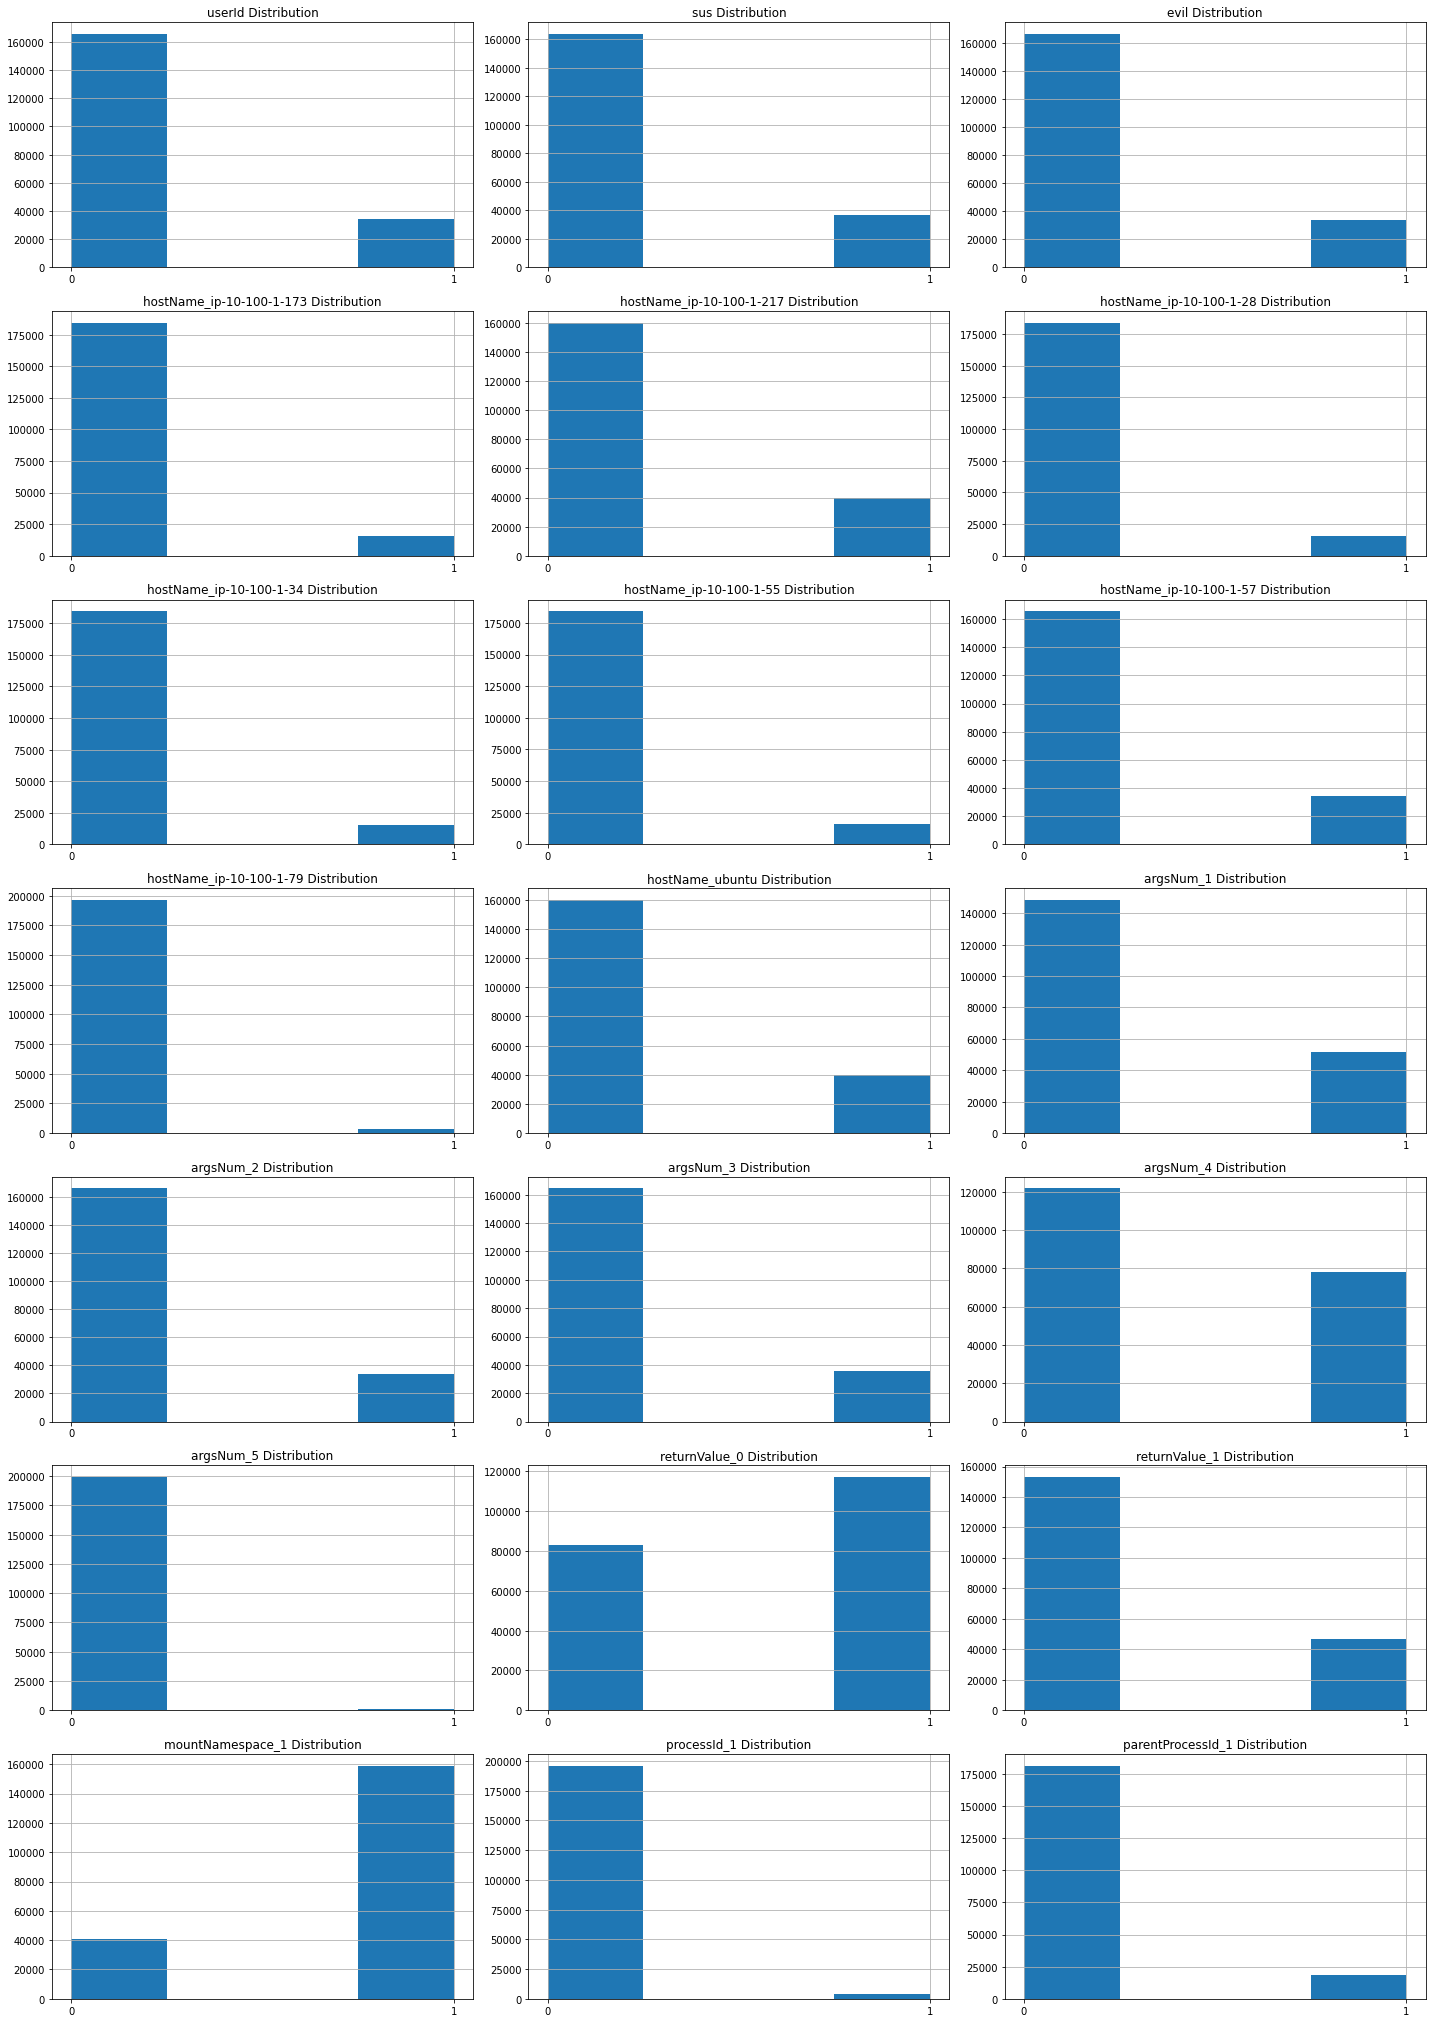

In [3]:
# inspiration for histogram code here: 
# https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,40))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=4,ax=ax)
        ax.set_title(var_name+" Distribution")
        plt.xticks(range(0,2))
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(data_subset, data_subset.columns, 10, 3)

### Data Distribution

The data distribution for each variable is shown above. Each variable has been encoded as a binary value, one-hot encoded, or both (`returnValue`). 

The first plot (top left) shows the distribution for the processId feature. Recall that if the processId in the data was 0, 1, or 2, the feature was encoded with a 0. All other values were encoded as a 1. Hence, it can be observed that most processIds were 0, 1, or 2. These values are meaningful since these are values used by the OS. If the OS doesn't use the process, a random number is assigned as the processId. Hence, we can observe that most of the processIds in the data are used by the OS. The next plot (top middle) was encoded using the same scheme and can be interpreted in the same way.  

Many of the distributions, such as those for `hostName` are interpreted as simply how many times the feature appears and doesn't appear. For example, comparing all the distributions for `hostName`, we can see that ubuntu is the most frequented honeypot. 

As expected, most events are neither suspicious nor evil. Also, the most common number of arguments is 4 and most return values indicate success rather than either failure or that a signal was passed to the parent process.  

Next, we'll explore correlations between these features. 

Since the typical correlation method is designed for continuous values, we'll have to look for an alternate method to get a similar measure for our categorical features. One appropriate method is Cramer's V with a correction for bias. Using this measure of association, we can first take a look at which features are most associated with activity that has been labelled as `evil`. 


In [4]:
# discussion on how to calculate correation of binary variables 
# here:
# https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
# and here: 
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# and here: 
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

#remove evil column from data set 
evil = data_subset.pop('evil')

#append evil column as final column in the dataset
data_subset.insert(len(data_subset.columns),'evil',evil)

#function to calculate association  
def cramers_corrected_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#Find features most correlated with 'evil'
top_features = []
for i in range(0,len(data_subset.columns)-1):
    #pass two columns at a time to the function to calculate correlation 
    #column1+evil, column2+evil, column3+evil, etc.
    top_features.append(cramers_corrected_v(data_subset.iloc[:,i], data_subset.iloc[:,len(data_subset.columns)-1]))

corr_with_evil = pd.DataFrame (top_features, columns = ['Features correlated with evil'])
corr_with_evil.index = data_subset.columns[:len(data_subset.columns)-1]
print(corr_with_evil)



                          Features correlated with evil
userId                                         0.977918
sus                                            0.949942
hostName_ip-10-100-1-173                       0.129348
hostName_ip-10-100-1-217                       0.899250
hostName_ip-10-100-1-28                        0.131297
hostName_ip-10-100-1-34                        0.129061
hostName_ip-10-100-1-55                        0.130729
hostName_ip-10-100-1-57                        0.204078
hostName_ip-10-100-1-79                        0.058393
hostName_ubuntu                                0.223298
argsNum_1                                      0.234435
argsNum_2                                      0.183559
argsNum_3                                      0.881688
argsNum_4                                      0.336921
argsNum_5                                      0.009774
returnValue_0                                  0.482876
returnValue_1                                  0

Here, we can see that the features most highly correlated with `evil` include `userId`, `sus`, `hostName_ip-10-100-1-217 `, and `argsNum_3`.  All other correlation values are lower than 0.50.  

These findings are not too surprising since the researchers state in their paper that an attack against host 10.100.1.217 was detected. The other correlation values suggest that the attacker may have used three arguments in his or her attack. Because these three features are so highly correlated with the `evil` label, they (along with the label `sus` will be removed from subsequent analysis.

Now that we've seen which features are correlated with malicious events, let's view the whole correlation heatmap showing association strength between all feature pairs. Note that the final column of the heatmap contains the same values as above with the exception of the features and label that have been removed. 

In [5]:
#remove mountNamespace_1 and hostName_ubuntu since they exhibit multicollinearity 

data_subset = data_subset.drop(columns=['userId','hostName_ip-10-100-1-217', 'argsNum_3', 'sus', 'hostName_ubuntu', 'mountNamespace_1'])


#uncomment to re-run, otherwise use saved results below. Re-running takes a minute or two.
corr_list = []
corr_list_of_lists = []
for i in range(0,len(data_subset.columns)):
    for j in range(0,len(data_subset.columns)):
        if i == j:
            corr_list.append(1.0)
        else:
            corr_list.append(cramers_corrected_v(data_subset.iloc[:,i], data_subset.iloc[:,j]))
    corr_list_of_lists.append(corr_list)
    corr_list = []
cramers_correlation = corr_list_of_lists

#Generate a correlation heatmap 
cc_df = pd.DataFrame(cramers_correlation)
cc_df.columns = data_subset.columns
cc_df.index = data_subset.columns
cc_df.style.background_gradient(cmap='coolwarm')



,hostName_ip-10-100-1-173,hostName_ip-10-100-1-28,hostName_ip-10-100-1-34,hostName_ip-10-100-1-55,hostName_ip-10-100-1-57,hostName_ip-10-100-1-79,argsNum_1,argsNum_2,argsNum_4,argsNum_5,returnValue_0,returnValue_1,processId_1,parentProcessId_1,evil
hostName_ip-10-100-1-173,1.000000,0.084747,0.083303,0.084380,0.131756,0.037628,0.022034,0.022560,0.094062,0.004864,0.068312,0.033950,0.026589,0.021394,0.129348
hostName_ip-10-100-1-28,0.084747,1.000000,0.084559,0.085653,0.133741,0.038199,0.021638,0.026140,0.098781,0.003556,0.070065,0.034836,0.016740,0.017011,0.131297
hostName_ip-10-100-1-34,0.083303,0.084559,1.000000,0.084193,0.131464,0.037544,0.021911,0.025988,0.097689,0.008158,0.069773,0.034271,0.002407,0.000000,0.129061
hostName_ip-10-100-1-55,0.084380,0.085653,0.084193,1.000000,0.133163,0.038033,0.024254,0.022439,0.093098,0.008161,0.067938,0.036393,0.003372,0.001913,0.130729
hostName_ip-10-100-1-57,0.131756,0.133741,0.131464,0.133163,1.000000,0.059482,0.048734,0.012004,0.054402,0.005596,0.118004,0.022005,0.038457,0.104669,0.204078
hostName_ip-10-100-1-79,0.037628,0.038199,0.037544,0.038033,0.059482,1.000000,0.011273,0.007466,0.040291,0.001775,0.034719,0.010487,0.026416,0.002514,0.058393
argsNum_1,0.022034,0.021638,0.021911,0.024254,0.048734,0.011273,1.000000,0.265504,0.471131,0.034829,0.481923,0.322828,0.005537,0.042442,0.234435
argsNum_2,0.022560,0.026140,0.025988,0.022439,0.012004,0.007466,0.265504,1.000000,0.361811,0.026671,0.301592,0.237330,0.030215,0.076742,0.183559
argsNum_4,0.094062,0.098781,0.097689,0.093098,0.054402,0.040291,0.471131,0.361811,1.000000,0.047552,0.277805,0.610749,0.010661,0.048527,0.336921
argsNum_5,0.004864,0.003556,0.008158,0.008161,0.005596,0.001775,0.034829,0.026671,0.047552,1.000000,0.006329,0.031571,0.005788,0.096552,0.009774



###  Transformations

No transformations of this data is necessary other than the one-hot-encoding done previously. 




## IV. Perform Analysis Using Supervised Machine Learning Models of your Choice, Present Discussion and Conclusions   

_Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization._

Given the nature of the data (categorical), the main analysis will consist of logistic regression, random forest, and support vector machines. We'll use each to predict (classify) whether the captured activity is evil or not evil. Logistic regression is used first since it's fast  and easy to understand. 

Since Logistic Regression is not very accurate and can tend to overfit, Random Forest will also be implemented. Random Forest has high accuracy, is fast, and flexible but can be slow at training and also prone to overfitting. Finally, SVM will be used as a point of comparison with the baseline and other two methods.   


### Baseline Accuracy

In this dataset, approximately 17% of logs are labelled as evil. The theoretical accuracy of random guessing is ```P(log is not evil) * P(you guess not evil) + P(log is evil) * P(you guess evil)```. In other words, ```(0.83) * (0.83) + (0.17) * (0.17) = 0.6889 + 0.0286 = 0.7178```. 

In contrast, the Zero Rule classifier simply predicts the majority class in the dataset. In this case, 83%. This is the baseline that will be used to compare other models against.

### Logistic Regression

In the next sections, the BETH dataset will be modeled using Logistic Regression in various forms. First, Logistic Regression will be done using default weights and hyperparameters. Next, weights will be applied specific to the distribution of the predicted feature. Following this, multiple models will be created using multiple weights, penalties, and other hyperparameters. Finally, Logistic Regression will be used to model the data using the most optimal outcome from the previous step.  


### Logistic Regression using Default Parameters


In [6]:
# Invaluable guidance and explanation for the Logistic Regression section here: 
# https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b

y = evil
# assign all columns except 'evil' to X, the input features
X = data_subset.drop(columns=['evil'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#Logistic Regression with default weights 
# define model
model = LogisticRegression(random_state=13, class_weight=None)
# fit it
model.fit(X_train,y_train)
# test
y_pred = model.predict(X_test)
# performance
default_lr_accuracy = accuracy_score(y_test,y_pred)
default_lr_cm = confusion_matrix(y_test, y_pred)
default_lr_auc = roc_auc_score(y_test, y_pred)
default_lr_precision = metrics.precision_score(y_test, y_pred)
default_lr_recall = recall_score(y_test,y_pred)


list_of_results = []
default_lr_results = ['Default Logistic Regression', 
                      default_lr_accuracy, 
                      default_lr_cm[0][0], default_lr_cm[0][1], default_lr_cm[1][0], default_lr_cm[1][1], 
                      default_lr_auc, default_lr_precision, default_lr_recall]

list_of_results.append(default_lr_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results.set_index("Method", inplace = True)
results

#print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
#print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
#print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
#print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
#print(f'Recall score: {recall_score(y_test,y_pred)}')


,Accuracy,TP,FP,FN,TN,AUC,Precision,Recall
Method,,,,,,,,
Default Logistic Regression,0.98378,41425,217,594,7764,0.96186,0.97281,0.92893


### Logistic Regression using Weights as the Inverse of Label Distribution 
In this model, the weight for the majority class is 17 and the weight of the minority class is 83. This means the penalty for the wrong prediction of the minority class will be 83 times more severe than the wrong prediction of the majority class. With these weights, we can expect this model to perform better than the default.

In [7]:
# define class weights
w = {0:17, 1:83}
# define model
model = LogisticRegression(random_state=13, class_weight=w, max_iter=1000)
# fit it
model.fit(X_train,y_train)
# test
y_pred = model.predict(X_test)
# performance

weighted_lr_accuracy = accuracy_score(y_test,y_pred)
weighted_lr_cm = confusion_matrix(y_test, y_pred)
weighted_lr_auc = roc_auc_score(y_test, y_pred)
weighted_lr_precision = metrics.precision_score(y_test, y_pred)
weighted_lr_recall = recall_score(y_test,y_pred)

weighted_lr_results = ['Weighted Logistic Regression', 
                      weighted_lr_accuracy, 
                      weighted_lr_cm[0][0], weighted_lr_cm[0][1], weighted_lr_cm[1][0], weighted_lr_cm[1][1], 
                      weighted_lr_auc, weighted_lr_precision, weighted_lr_recall]

list_of_results.append(weighted_lr_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results

,Method,Accuracy,TP,FP,FN,TN,AUC,Precision,Recall
0,Default Logistic Regression,0.98378,41425,217,594,7764,0.961860,0.972810,0.928930
1,Weighted Logistic Regression,0.98348,41393,249,577,7781,0.962492,0.968991,0.930964


### Logistic Regression using Weights/Hyperparameters GridSearch. 

There may be other combinations of weights and hyperparameters that result in better performance. The next model uses the provided list of weights and other hyperparameters and returns the values corresponding to the best result.   

Unfortunately this ran over night and didn't return a result. 

In [8]:
# define hyperparameters

#rng = np.random.RandomState(0)
#X, y = datasets.make_classification(n_samples=1000, random_state=rng)

w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]

crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l2"] #l1 not compatible with lbgfs
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

model = LogisticRegression(random_state=13,max_iter=1000)
# define evaluation procedure
# speed up tips here: https://stackoverflow.com/questions/35655701/is-there-a-quicker-way-of-running-gridsearchcv
# switched to RandomizedSearchCV to speed up execution
grid = RandomizedSearchCV(model, hyperparam_grid, cv= 3, scoring="accuracy", n_jobs = -1, error_score='raise')
%time grid.fit(X, y)

#grid = GridSearchCV(model,hyperparam_grid,scoring="roc_auc", cv=3, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

CPU times: user 4.79 s, sys: 537 ms, total: 5.33 s
Wall time: 21.9 s
Best score: 0.9778800057489226 with param: {'penalty': 'l2', 'fit_intercept': True, 'class_weight': {0: 1.0, 1: 10}, 'C': 4.0}


### Optimal Logistic Regression Model 

The following model uses the provided best parameters to generate what should be the best logistic regression model outcomes. 

In [9]:
# define model

model = LogisticRegression(random_state=13,C=grid.best_params_['C'],fit_intercept=grid.best_params_['fit_intercept'], 
    penalty=grid.best_params_['penalty'],class_weight=grid.best_params_['class_weight'] )
# fit it
model.fit(X_train,y_train)
# test
y_pred = model.predict(X_test)
# performance

optimal_lr_accuracy = accuracy_score(y_test,y_pred)
optimal_lr_cm = confusion_matrix(y_test, y_pred)
optimal_lr_auc = roc_auc_score(y_test, y_pred)
optimal_lr_precision = metrics.precision_score(y_test, y_pred)
optimal_lr_recall = recall_score(y_test,y_pred)

optimal_lr_results = ['Optimal Logistic Regression', 
                      optimal_lr_accuracy, 
                      optimal_lr_cm[0][0], optimal_lr_cm[0][1], optimal_lr_cm[1][0], optimal_lr_cm[1][1], 
                      optimal_lr_auc, optimal_lr_precision, optimal_lr_recall]

list_of_results.append(optimal_lr_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results
#print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
#print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
#print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
#print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
#print(f'Recall score: {recall_score(y_test,y_pred)}')

/Users/swade/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Method,Accuracy,TP,FP,FN,TN,AUC,Precision,Recall
0,Default Logistic Regression,0.98378,41425,217,594,7764,0.961860,0.972810,0.928930
1,Weighted Logistic Regression,0.98348,41393,249,577,7781,0.962492,0.968991,0.930964
2,Optimal Logistic Regression,0.97710,41058,584,561,7797,0.959427,0.930319,0.932879


### Random Forest

Although the model may have changed, we still need to consider the imbalance of the data. Again, we'll follow a three-step process. First use Random Forest to model the data with default values. Next, we'll generate results for a Balanced Random Forest Classifier. Finally, we'll use the SMOTE (Synthetic Minority Oversampling Technique) method with the random forest algorithm. SMOTE is a common technique for performing imbalanced classification.


In [10]:
# Random Forest with Class Weighting to deal with imbalanced classification inspired by this site:
# https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
# also
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification

#print(sum(evil))
#print(len(evil))

#Create a Gaussian Classifier

clf = RandomForestClassifier(n_estimators=10, class_weight='balanced')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

default_rf_accuracy = accuracy_score(y_test,y_pred)
default_rf_cm = confusion_matrix(y_test, y_pred)
default_rf_auc = roc_auc_score(y_test, y_pred)
default_rf_precision = metrics.precision_score(y_test, y_pred)
default_rf_recall = recall_score(y_test,y_pred)

default_rf_results = ['Default Random Forest', 
                      default_rf_accuracy, 
                      default_rf_cm[0][0], default_rf_cm[0][1], default_rf_cm[1][0], default_rf_cm[1][1], 
                      default_rf_auc, default_rf_precision, default_rf_recall]

list_of_results.append(default_rf_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results

,Method,Accuracy,TP,FP,FN,TN,AUC,Precision,Recall
0,Default Logistic Regression,0.98378,41425,217,594,7764,0.961860,0.972810,0.928930
1,Weighted Logistic Regression,0.98348,41393,249,577,7781,0.962492,0.968991,0.930964
2,Optimal Logistic Regression,0.97710,41058,584,561,7797,0.959427,0.930319,0.932879
3,Default Random Forest,0.98572,41522,120,594,7764,0.963024,0.984779,0.928930


### Random Forest Balanced Classifier

Add some description here of what this is and what's expected 

In [11]:
#Build SRF model
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate BRFC model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
#Get average evaluation metrics
#print('Mean f1: %.3f' % mean(scores['test_f1']))
#print('Mean recall: %.3f' % mean(scores['test_recall']))
#print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train BRFC
BRFC.fit(X_train, y_train)
#BRFC prediction result
y_pred = BRFC.predict(X_test)

balanced_rf_accuracy = accuracy_score(y_test,y_pred)
balanced_rf_cm = confusion_matrix(y_test, y_pred)
balanced_rf_auc = roc_auc_score(y_test, y_pred)
balanced_rf_precision = metrics.precision_score(y_test, y_pred)
balanced_rf_recall = recall_score(y_test,y_pred)

balanced_rf_results = ['Balanced Random Forest', 
                      balanced_rf_accuracy, 
                      balanced_rf_cm[0][0], balanced_rf_cm[0][1], balanced_rf_cm[1][0], balanced_rf_cm[1][1], 
                      balanced_rf_auc, balanced_rf_precision, balanced_rf_recall]

list_of_results.append(balanced_rf_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results

,Method,Accuracy,TP,FP,FN,TN,AUC,Precision,Recall
0,Default Logistic Regression,0.98378,41425,217,594,7764,0.961860,0.972810,0.928930
1,Weighted Logistic Regression,0.98348,41393,249,577,7781,0.962492,0.968991,0.930964
2,Optimal Logistic Regression,0.97710,41058,584,561,7797,0.959427,0.930319,0.932879
3,Default Random Forest,0.98572,41522,120,594,7764,0.963024,0.984779,0.928930
4,Balanced Random Forest,0.98600,16600,61,219,3120,0.965375,0.980824,0.934412


### Synthetic Minority Oversampling Technique (SMOTE)   

SMOTE is the most common technique for handling classification problems when the data set is imbalanced. Here it is used in an effort to improve on the default Random Forest classifier results. 


In [ ]:
# Use SMOTE to oversample the minority class
# More info on SMOTE here: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
# Nice write up on SMOTE here: https://www.kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly split dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
#Train SMOTE SRF

SMOTE_SRF.fit(over_X_train, over_y_train)
%time SMOTE_SRF.fit(X, y)

#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

smote_rf_accuracy = accuracy_score(y_test,y_pred)
smote_rf_cm = confusion_matrix(y_test, y_pred)
smote_rf_auc = roc_auc_score(y_test, y_pred)
smote_rf_precision = metrics.precision_score(y_test, y_pred)
smote_rf_recall = recall_score(y_test,y_pred)

smote_rf_results = ['SMOTE Random Forest', 
                      smote_rf_accuracy, 
                      smote_rf_cm[0][0], smote_rf_cm[0][1], smote_rf_cm[1][0], smote_rf_cm[1][1], 
                      smote_rf_auc, smote_rf_precision, smote_rf_recall]

list_of_results.append(smote_rf_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results

### Support Vector Machine 

This section will implement SVM. There is just one version of this technique since modifications don't change outcomes in any meaningful way. 


In [ ]:
clf = svm.SVC(kernel = 'linear')
print("clf: ", clf)
clf.fit(X_train, y_train)
%time clf.fit(X, y)

y_pred = clf.predict(X_test)

default_svm_accuracy = accuracy_score(y_test,y_pred)
default_svm_cm = confusion_matrix(y_test, y_pred)
default_svm_auc = roc_auc_score(y_test, y_pred)
default_svm_precision = metrics.precision_score(y_test, y_pred)
default_svm_recall = recall_score(y_test,y_pred)

default_svm_results = ['SMOTE Random Forest', 
                      default_svm_accuracy, 
                      default_svm_cm[0][0], default_svm_cm[0][1], default_svm_cm[1][0], default_svm_cm[1][1], 
                      default_svm_auc, default_svm_precision, default_svm_recall]

list_of_results.append(default_svm_results)
                               
results = pd.DataFrame(list_of_results, columns=['Method', 'Accuracy', 'TP', 'FP', 'FN', 'TN', 'AUC', 'Precision', 'Recall'])
results

### Conclusions  
The following table summarizes results for the three techniques with their variations. Recall that the baseline threshold is 83%. 

A perfect classifier has precision and recall both equal to 1."

## V. Produce Deliverables:   
A video presentation of this Jupyter notebook is available on GitHub at 

### Video presentation

### GitHub Repository   


